# Attack Classifier Experiments
*Author: Saiid El Hajj Chehade | sae55@mail.aub.edu*

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.compose import make_column_selector as selector
from typing import Tuple

# Loading the data

### Dataset source 
https://drive.google.com/drive/folders/1rDEEQ9CyMWd2ZH3V-eyaBEEBkeL54zii 
### Dataset dimensions
- 30 features: 22 useful features
- 17 classes: 16 positive classes and 1 `NORMAL` class

Number of samples: 33388
30 features
17 classes: ['ACK' 'FIN' 'NUL' 'WINDOW' 'MAIMON' 'XMAS' 'UDP' 'ECHOPING' 'IPPING'
 'OSDETECT' 'SERVICEVERSIONSCAN' 'SYN' 'TIMEPING' 'PINGONLY' 'PORTSCAN'
 'TCP' 'NORMAL']


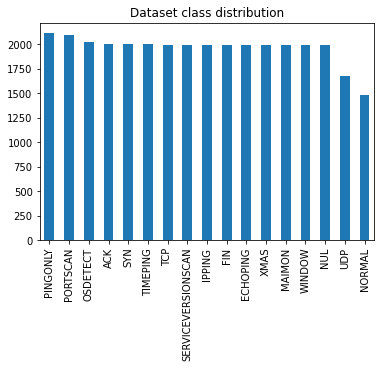

In [ ]:
def load_data(data_fp: str) -> Tuple[pd.DataFrame, list]:
  """
  loads the dataset

  Args:
    data_fp <string>: filepath
  
  Returns:
    Pandas DataFrame
  """

  # loading the CSV dataset
  data = pd.read_csv(data_fp) 
  classes = data.Class.unique()

  return data, classes

data, classes = load_data("Final_DataFrame_Updated (1).csv")

print(f"Number of samples: {len(data)}")
print(f"{len(data.columns)-1} features")
print(f"{len(classes)} classes: {classes}")
data.Class.value_counts().plot.bar()
plt.title("Dataset class distribution")
plt.show()

In [ ]:

def get_features(data: pd.DataFrame) -> set:
  """
  Gets the unique features with useful values

  Args:
    data <pd.DataFrame>
  
  Returns:
    set
  """
  # remove the labels from the features
  features = data.columns[:-1]

  # remove columns with fixed values
  cols_to_remove = set(["attack_id", "attack_id_1", "Class"])
  for col in features:
    if len(data[col].unique()) == 1:
      cols_to_remove.add(col)

  return set(features) - cols_to_remove

features = get_features(data)

print(f"{len(features)} useful features: {', '.join(features)}")


22 useful features: Dst Host Serror Rate, Dst Host Srv Serror Rate, Diff Srv Rate, Src Bytes, Dst Host Count, Same Srv Rate, Serror Rate, Count, Duration, Dst Host Diff Srv Rate, Srv Serror Rate, Srv Diff Host Rate, Dst Host Srv Diff Host Rate, Urgent, Dst Bytes, Dst Host Srv Count, Protocol Type, Dst Host Same Src Port Rate, Srv Count, Service, Flag, Dst Host Same Srv Rate


Overall, the dataset is balanced with minor inbalance for NORMAL dataset. This is not critical since the model should be preceded with a detector that filters out normal traffic.

The features that are not useful include  values that are constant in all the dataset. 



3 categorical: ['Flag', 'Protocol Type', 'Service']
8 int64: ['Count', 'Srv Count', 'Duration', 'Urgent', 'Src Bytes', 'Dst Bytes', 'Dst Host Srv Count', 'Dst Host Count']
11 float64: ['Srv Serror Rate', 'Dst Host Same Src Port Rate', 'Dst Host Serror Rate', 'Dst Host Srv Serror Rate', 'Srv Diff Host Rate', 'Dst Host Srv Diff Host Rate', 'Diff Srv Rate', 'Same Srv Rate', 'Dst Host Diff Srv Rate', 'Dst Host Same Srv Rate', 'Serror Rate']


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

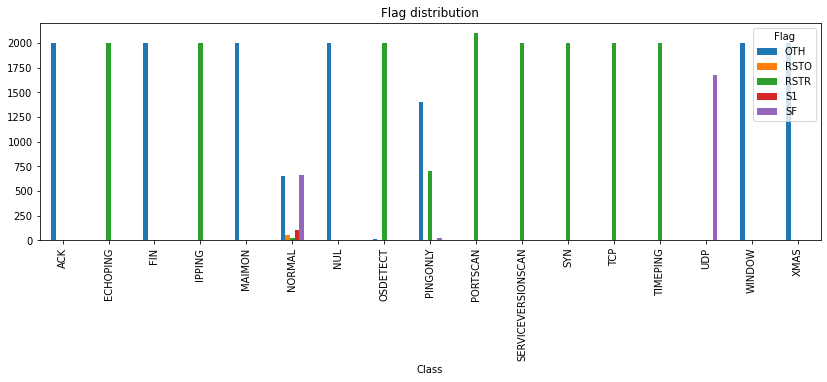

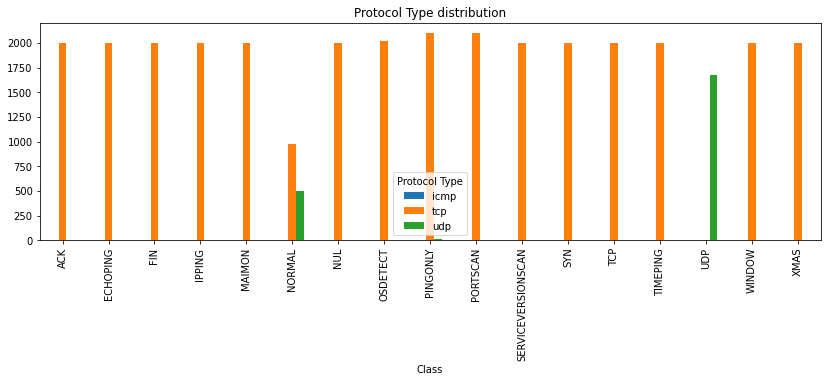

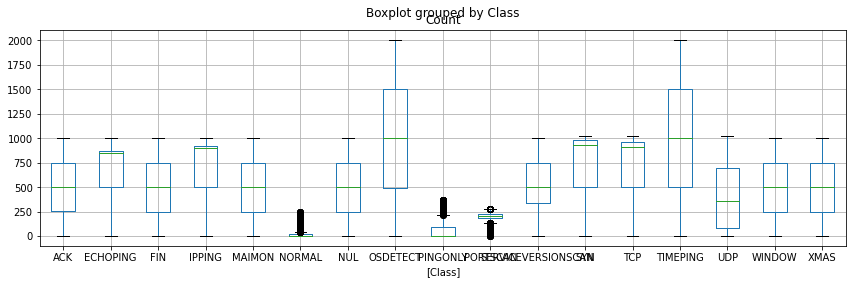

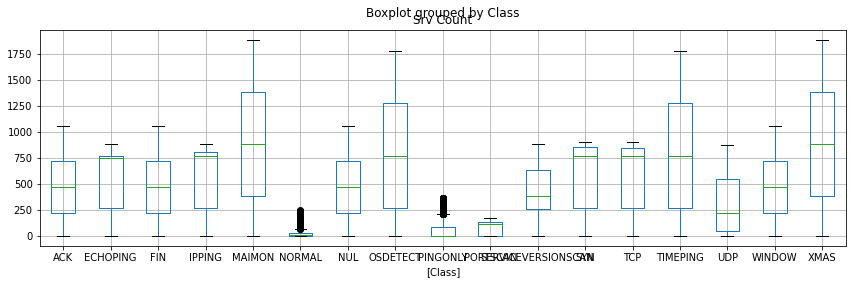

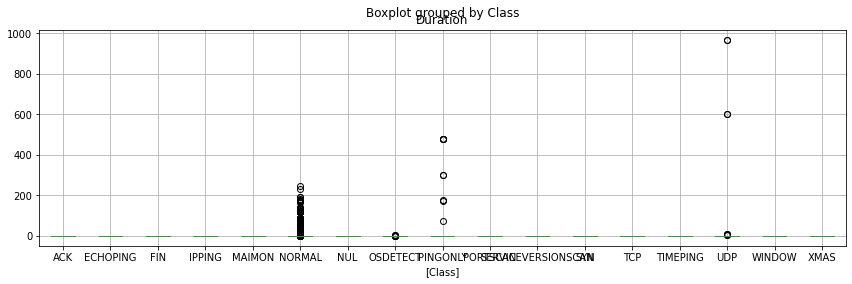

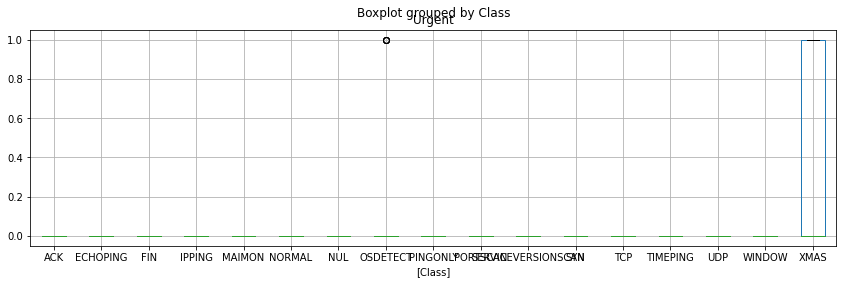

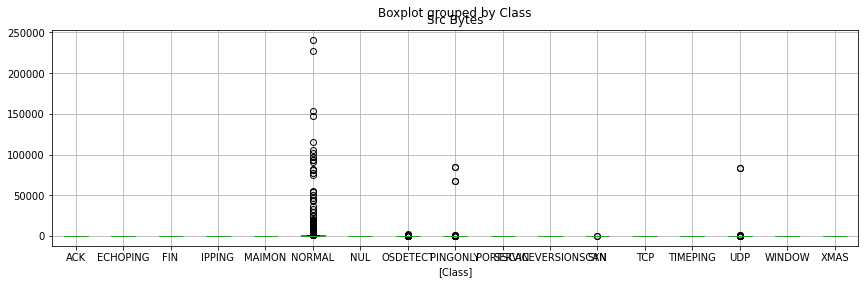

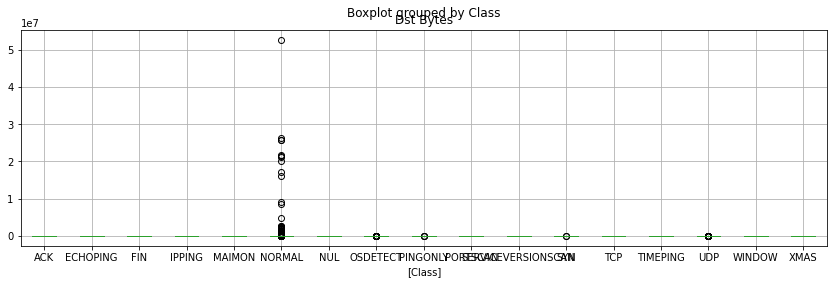

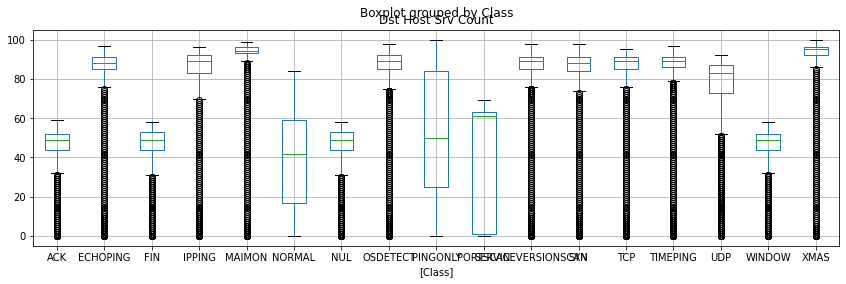

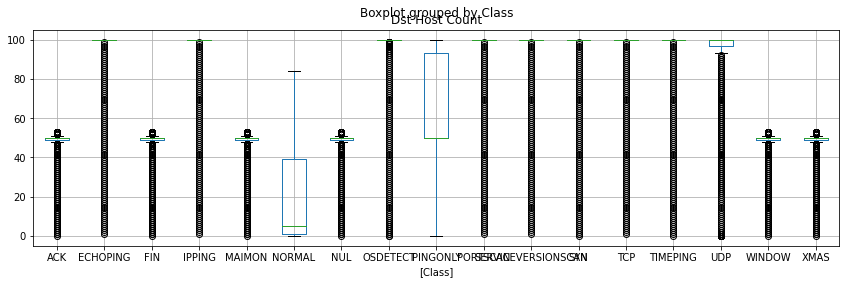

In [ ]:

def get_features_types(data: pd.DataFrame) -> Tuple[list, list, list, list]:
  """
  Gets whether the features are categorical, discrete or countinuous

  Args:
    data <pd.DataFrame>
  
  Returns:
    <set> all features, <list> categorical features, <list> discrete features, <list> countinuous features
  """

  features = get_features(data)

  cat_ftrs = list(set(data.select_dtypes(include='object').columns) & features)
  dsc_ftrs = list(set(data.select_dtypes(include="int64").columns) & features)
  cnt_ftrs = list(set(data.select_dtypes(include="float64").columns) & features)

  return features, cat_ftrs, dsc_ftrs, cnt_ftrs


features, cat_ftrs, dsc_ftrs, cnt_ftrs = get_features_types(data)

print(f"\n\n{len(cat_ftrs)} categorical: {cat_ftrs}")
print(f"{len(dsc_ftrs)} int64: {dsc_ftrs}")
print(f"{len(cnt_ftrs)} float64: {cnt_ftrs}")

for ft in cat_ftrs:
  if ft != "Service":
    pd.crosstab(data.Class, data[ft]).plot.bar( figsize=(14, 4))
    plt.title(ft+" distribution")

for ft in dsc_ftrs:
  data[[ft,'Class']].boxplot(by="Class", figsize=(14, 4))

1. `UDP` prdictor of UDP attack with some false negatives for normal requests
2. `Services` are not uniform over classes -> good predictors
3. `RSTR` flag and `OTH` flag are the most common -> we could split accross it
3. `SF flag` is unique to UDP attack
4. `Src Bytes`: The largest variability is for `NORMAL` conversations
5. `DST Host Srv Count` varies well across classes
6. `Count` is uniform across classes -> bad predictor -> consider removing it
7. `Duration` has the most variability in NORMAL conversations
8. `Dst Host Count` is very erratic -> bad predictor
9. `Dst Bytes` is good predictor of NORMAL
10. `Urgent` flag is only visible in XMAS attack
11. `Srv Count` is normally distributed -> good predictor

In [ ]:
for ft in cat_ftrs:
  print(f"{ft} -> {len(data[ft].unique())} unique values")


Flag -> 5 unique values
Protocol Type -> 3 unique values
Service -> 44 unique values


# Data preparation
1. One-hot encoding for the categorical features
2. Normalization for the numerical features

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, classification_report
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

In [ ]:
# one hot encoding
in_oh_encoder = OneHotEncoder(sparse=False, dtype='float')
data_cat = in_oh_encoder.fit_transform(data[cat_ftrs])
data_num = data[dsc_ftrs + cnt_ftrs].to_numpy()

# concatenate the features and transform to numpy
X = np.concatenate([data_num, data_cat], axis=1)
y = data['Class'].to_numpy()

# train test split, shuffling might create a problem later for sequencing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, stratify=y)

# scaling the features
scaler = StandardScaler()

X_train[:, 0:data_num.shape[1]] = scaler.fit_transform(X_train[:, 0:data_num.shape[1]])
X_test[:, 0:data_num.shape[1]] = scaler.transform(X_test[:, 0:data_num.shape[1]])

# Model Selection
We try a standard set of classifiers. 
We first stick to non DNN classifiers, because we hypothesise that attacks are easily seperable according to specific attributes (mainly categorical) due to the distributions plotted in prior sections. Using this assumption, we expect the **Random Forest** to do the best among these models:

1. Random Forest with 100 estimators
2. One-vs-Rest classifier based on Random Forest
3. One-vs-One classifier based on Random Forest
4. Multi-Layer Perceptron 
5. K-Neighbors classifier
6. Support Vector Classifer 
7. Suppoer Vector Classifier with linear kernel
8. Gaussian Process Classifier
9. Ada boost ensemble
10. Quadaratic Discriminant Analysis

In [ ]:
# Initial set of classifiers to test
classifiers = {
    'clf_rf' : RandomForestClassifier(n_estimators=100),
    'clf_rf_1n': OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=100), n_jobs=4),
    'clf_rf_mn': OneVsOneClassifier(estimator=RandomForestClassifier(n_estimators=100), n_jobs=4),
    'clf_mlp': MLPClassifier(alpha=0.1, max_iter=1000),
    'clf_knn': KNeighborsClassifier(5),
    'clf_svc': SVC(gamma=2, C=1),
    'clf_svc_linear': SVC(kernel='linear', C=0.025),
    'clf_ada': AdaBoostClassifier(),
}

clf_rf
                    precision    recall  f1-score   support

               ACK       0.77      0.78      0.77       601
          ECHOPING       0.78      0.78      0.78       599
               FIN       0.78      0.79      0.78       600
            IPPING       0.78      0.81      0.79       600
            MAIMON       0.89      0.92      0.91       600
            NORMAL       0.99      1.00      0.99       444
               NUL       0.86      0.88      0.87       599
          OSDETECT       0.87      0.83      0.85       606
          PINGONLY       0.99      1.00      0.99       635
          PORTSCAN       0.97      0.97      0.97       630
SERVICEVERSIONSCAN       0.82      0.79      0.81       600
               SYN       0.73      0.76      0.75       600
               TCP       1.00      1.00      1.00       600
          TIMEPING       0.81      0.79      0.80       600
               UDP       1.00      0.99      1.00       503
            WINDOW       0.79   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

               ACK       0.00      0.00      0.00       601
          ECHOPING       0.00      0.00      0.00       599
               FIN       0.17      0.00      0.00       600
            IPPING       0.00      0.00      0.00       600
            MAIMON       0.24      0.07      0.11       600
            NORMAL       0.07      0.57      0.13       444
               NUL       0.00      0.00      0.00       599
          OSDETECT       0.12      0.81      0.21       606
          PINGONLY       0.46      0.29      0.35       635
          PORTSCAN       0.50      0.97      0.66       630
SERVICEVERSIONSCAN       0.00      0.00      0.00       600
               SYN       0.10      0.03      0.04       600
               TCP       0.00      0.00      0.00       600
          TIMEPING       0.00      0.00      0.00       600
               UDP       0.36      0.05      0.09       503
            WINDOW       0.00      0.00

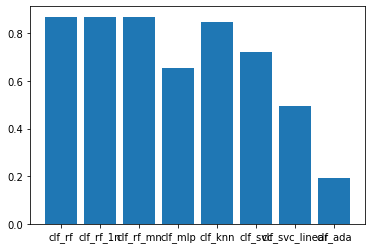

In [ ]:
# Area under the curve metrics
roc_auc = []

for classifier_name, clf in classifiers.items():
  
  print(classifier_name)

  # train the model
  clf.fit(X_train, y_train)

  # evaluate the model
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))

  # add the result to the list
  roc_auc.append(clf.score(X_test, y_test))

# plot result
plt.bar(list(classifiers.keys()), roc_auc)
print(roc_auc)


# Compiling Best Model into Pipeline

score:  0.8641808924827793
                    precision    recall  f1-score   support

               ACK       0.72      0.79      0.76       408
          ECHOPING       0.76      0.77      0.76       404
               FIN       0.82      0.79      0.81       415
            IPPING       0.77      0.80      0.79       378
            MAIMON       0.91      0.89      0.90       415
            NORMAL       0.99      1.00      0.99       300
               NUL       0.85      0.86      0.86       396
          OSDETECT       0.87      0.86      0.86       364
          PINGONLY       0.99      1.00      0.99       475
          PORTSCAN       0.96      0.97      0.97       410
SERVICEVERSIONSCAN       0.81      0.81      0.81       410
               SYN       0.78      0.72      0.75       411
               TCP       1.00      1.00      1.00       386
          TIMEPING       0.80      0.82      0.81       398
               UDP       1.00      1.00      1.00       327
            

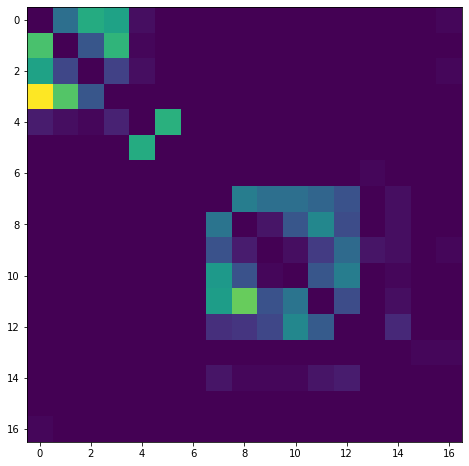

In [ ]:
import pickle

class FeaturesSubset:
  def __init__(self, features, to_numpy=True):
        self.features = features
        self.to_numpy = to_numpy

  def transform(self, X, **transform_params):
        if self.to_numpy:
          return pd.DataFrame(X[self.features]).values
        else:
          return pd.DataFrame(X[self.features])

  def fit_transform(self, X, y, **transform_params):
        return self.transform(X, **transform_params)

  def fit(self, X, y=None, **fit_params):
    return self

# model building
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('categorical', Pipeline([
            ('subset', FeaturesSubset(cat_ftrs, to_numpy=False)),
            ('one_hot', OneHotEncoder(sparse=False, dtype='float')),
            
        ])),
        ('numerical', Pipeline([
            ('subset', FeaturesSubset(cnt_ftrs + dsc_ftrs)),
            ('scaler', StandardScaler()),
        ]))
    ])), 
    ('rf',RandomForestClassifier(n_estimators=100))])



data_train=data.sample(frac=0.8)
data_test=data.drop(data_train.index)

pipeline.fit(data_train, data_train.Class)
print("score: ", pipeline.score(data_test, data_test.Class))

pickle.dump(pipeline, open("model.sav", 'wb'))

with open("features.txt", "w") as f:
  f.write("\n".join(features))
  

data_val=data_test.sample(frac=1)
y_pred = list(pipeline.predict(data_val))
y_true = list(data_val.Class.values)
print(classification_report(y_true, y_pred))

# we plot the confusion matrix
c = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(8,8))
plt.imshow(c - np.diag(np.diag(c)))


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential(
    layers = [
        tf.keras.layers.Input(shape= (X.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1028, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='sigmoid'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 71)               284       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 1028)              74016     
                                                                 
 dense_7 (Dense)             (None, 512)               526848    
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                      

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives() ]
)

In [ ]:
# output class preprocessing
out_one_hot_encoder = OneHotEncoder(sparse=False, dtype='float')
y_nn_train = out_one_hot_encoder.fit_transform(y_train.reshape(-1,1))
y_nn_test = out_one_hot_encoder.transform(y_test.reshape(-1,1))

In [ ]:
model.fit(
    X_train, 
    y_nn_train,
    epochs=100,
    batch_size=64,
    validation_split = 0.1

    )

Epoch 1/100
329/329 [==============================] - 12s 37ms/step - loss: 1.0905 - accuracy: 0.5078 - false_negatives_4: 13379.0000 - false_positives_4: 1533.0000 - val_loss: 1.0316 - val_accuracy: 0.5304 - val_false_negatives_4: 1405.0000 - val_false_positives_4: 194.0000
Epoch 2/100
329/329 [==============================] - 14s 41ms/step - loss: 1.0646 - accuracy: 0.5155 - false_negatives_4: 13335.0000 - false_positives_4: 1490.0000 - val_loss: 1.0057 - val_accuracy: 0.5389 - val_false_negatives_4: 1425.0000 - val_false_positives_4: 187.0000
Epoch 3/100
329/329 [==============================] - 11s 32ms/step - loss: 1.0433 - accuracy: 0.5207 - false_negatives_4: 13208.0000 - false_positives_4: 1424.0000 - val_loss: 1.0557 - val_accuracy: 0.5351 - val_false_negatives_4: 1464.0000 - val_false_positives_4: 198.0000
Epoch 4/100
329/329 [==============================] - 10s 31ms/step - loss: 1.0447 - accuracy: 0.5181 - false_negatives_4: 13248.0000 - false_positives_4: 1528.0000 - v